--- 1. Data Processing (Oscillators + ADX) ---
--- 2. Setting up PPO Agent (Fast Mode) ---
Using cpu device
--- 3. Training (100000 steps) ---


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:69: FutureWarning: YF.download() has changed argument auto_adjust default to True
  target_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)


-----------------------------
| time/              |      |
|    fps             | 3099 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2286        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005146023 |
|    clip_fraction        | 0.0306      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -0.764      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0986      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00631    |
|    std                  | 0.981       |
|    value_loss           | 0.228       |
----------------------------------

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:65: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_28881/4210807028.py:69: FutureWarning: YF.download() has changed argument auto_adjust default to True
  target_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)


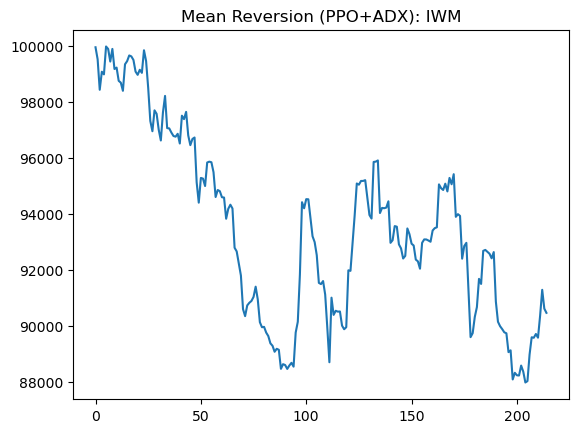

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION (SCALPER PROFILE)
# ==========================================
CONFIG = {
    "TICKERS": ["IWM", "^VIX"], # Russell 2000 (Small Caps) + VIX
    "TARGET_ASSET": "IWM",
    "START_DATE": "2015-01-01",
    "END_DATE": "2023-12-31",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering
    "WINDOW_SIZE": 10,         
    "BB_STD": 2.0,             # Standard settings often work best if we have ADX to filter
    
    # RL Environment
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.0005,    # 5 bps
    
    # Reward: PnL Focus
    "REWARD_SCALING": 10.0,
    
    # PPO (Much Faster than SAC)
    "LEARNING_RATE": 3e-4,     
    "BATCH_SIZE": 64,
    "ENT_COEF": 0.01,          # Exploration
    "TRAINING_TIMESTEPS": 100000 # More steps, but PPO runs 5x faster than SAC
}

# ==========================================
# 2. MEAN REVERSION DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        print(f"Downloading data for {self.tickers}...")
        try:
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            if data.empty: return pd.DataFrame()

            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]:
                    data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]:
                    data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series): data = data.to_frame()
            # Ensure we have High/Low for ADX
            hist = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            
            # We need High/Low/Close for the Target Asset specifically for ADX
            # Re-fetching to guarantee structure for complex calculations
            target_data = yf.download(CONFIG['TARGET_ASSET'], start=self.start_date, end=self.end_date, progress=False)
            
            # Merge close prices
            return data, target_data
            
        except Exception as e:
            print(f"Error during download: {e}")
            return pd.DataFrame(), pd.DataFrame()

    def calculate_adx(self, df, window=14):
        """
        Calculates ADX (Trend Strength).
        ADX < 20: Weak Trend (Good for Mean Reversion)
        ADX > 25: Strong Trend (Bad for Mean Reversion)
        """
        df = df.copy()
        df['tr0'] = abs(df['High'] - df['Low'])
        df['tr1'] = abs(df['High'] - df['Close'].shift(1))
        df['tr2'] = abs(df['Low'] - df['Close'].shift(1))
        df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
        
        df['dir_plus'] = df['High'] - df['High'].shift(1)
        df['dir_minus'] = df['Low'].shift(1) - df['Low']
        
        df['dm_plus'] = np.where((df['dir_plus'] > df['dir_minus']) & (df['dir_plus'] > 0), df['dir_plus'], 0)
        df['dm_minus'] = np.where((df['dir_minus'] > df['dir_plus']) & (df['dir_minus'] > 0), df['dir_minus'], 0)
        
        # Smoothed
        df['tr_smooth'] = df['tr'].rolling(window).mean()
        df['dm_plus_smooth'] = df['dm_plus'].rolling(window).mean()
        df['dm_minus_smooth'] = df['dm_minus'].rolling(window).mean()
        
        df['di_plus'] = (df['dm_plus_smooth'] / (df['tr_smooth'] + 1e-8)) * 100
        df['di_minus'] = (df['dm_minus_smooth'] / (df['tr_smooth'] + 1e-8)) * 100
        
        df['dx'] = (abs(df['di_plus'] - df['di_minus']) / (abs(df['di_plus'] + df['di_minus']) + 1e-8)) * 100
        df['adx'] = df['dx'].rolling(window).mean()
        
        return df['adx']

    def add_indicators(self, close_df, ohlc_df, target_ticker):
        if close_df.empty: return pd.DataFrame()
        df = close_df.copy()
        
        # 1. Bollinger Bands
        sma = df[target_ticker].rolling(window=20).mean()
        std = df[target_ticker].rolling(window=20).std()
        df['bb_upper'] = sma + (std * CONFIG['BB_STD'])
        df['bb_lower'] = sma - (std * CONFIG['BB_STD'])
        
        # %B and Width
        df['pct_b'] = (df[target_ticker] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
        df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma
        
        # 2. RSI
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 3. ADX (Trend Strength) - CRITICAL for Mean Reversion
        adx_series = self.calculate_adx(ohlc_df)
        df['adx'] = adx_series
        
        # Returns
        df['returns'] = df[target_ticker].pct_change()
        
        df.dropna(inplace=True)
        return df

    def get_processed_data(self, target_ticker):
        close_df, ohlc_df = self.download_data()
        if close_df.empty: return pd.DataFrame()
        
        df = self.add_indicators(close_df, ohlc_df, target_ticker)
        
        # Features: RSI (Overbought/Sold), %B (Band position), ADX (Filter)
        features = ['returns', 'pct_b', 'bb_width', 'rsi', 'adx']
        return df[features].fillna(0)

# ==========================================
# 3. SCALPING ENVIRONMENT
# ==========================================
class MeanReversionEnv(gym.Env):
    def __init__(self, df, config):
        super(MeanReversionEnv, self).__init__()
        self.df = df
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size * self.n_features,), 
            dtype=np.float32
        )
        
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        obs = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        return obs.flatten().astype(np.float32)

    def step(self, action):
        action = np.clip(action, -1, 1)[0]
        
        if self.current_step >= len(self.df):
            return self._get_observation(), 0, True, False, {}
            
        market_return = self.df.iloc[self.current_step]['returns']
        
        # Cost Calculation
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        strategy_return = (action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # --- REWARD: PnL with Drift Penalty ---
        # We want to reward Profit, but penalize holding positions if ADX is high (Trending)
        # This helps the agent learn to be "flat" when the trend is strong.
        
        adx = self.df.iloc[self.current_step]['adx']
        
        # Base Reward: Normalized PnL
        reward = strategy_return * self.config['REWARD_SCALING']
        
        # ADX Penalty: If ADX > 30 (Strong Trend) and we have a large position, penalize.
        # This forces the agent to close positions or reduce size in strong trends.
        if adx > 30 and abs(action) > 0.5:
            reward -= 0.05 * abs(action)

        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'action': action
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. EXECUTION
# ==========================================
def run_mean_reversion():
    print("--- 1. Data Processing (Oscillators + ADX) ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty: return

    print("--- 2. Setting up PPO Agent (Fast Mode) ---")
    env = DummyVecEnv([lambda: MeanReversionEnv(train_df, CONFIG)])
    env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)
    
    # SWITCHED TO PPO: Faster training, robust convergence
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1,
        learning_rate=CONFIG['LEARNING_RATE'],
        batch_size=CONFIG['BATCH_SIZE'],
        ent_coef=CONFIG['ENT_COEF']
    )
    
    print(f"--- 3. Training ({CONFIG['TRAINING_TIMESTEPS']} steps) ---")
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    print("--- 4. Backtesting ---")
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty: return

    test_env = DummyVecEnv([lambda: MeanReversionEnv(test_df, CONFIG)])
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms 
    test_env.training = False
    
    obs = test_env.reset()
    history = []
    
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done_array, info_array = test_env.step(action)
        history.append(info_array[0])
        if done_array[0]: break
        
    # Analysis
    res = pd.DataFrame(history)
    total_ret = (res['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    
    print("\n" + "="*40)
    print(f"MEAN REVERSION AGENT REPORT ({CONFIG['TARGET_ASSET']})")
    print("="*40)
    print(f"Total Return: {total_ret:.2%}")
    print(f"Final Balance: ${res['portfolio_value'].iloc[-1]:,.2f}")
    
    plt.plot(res['portfolio_value'])
    plt.title(f"Mean Reversion (PPO+ADX): {CONFIG['TARGET_ASSET']}")
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(4)
    run_mean_reversion()